In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline 

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!ls "/content/drive/My Drive/Dataset"

imdb_label.csv	imdb_tr.csv  Test.csv  Train.csv
imdb_text.csv	label.txt    Test.txt  Valid.txt


In [ ]:
ds = pd.read_csv('/content/drive/My Drive/Dataset/Train.csv', encoding='latin-1')

In [ ]:
ds_test = pd.read_csv('/content/drive/My Drive/Dataset/Test.csv', encoding='latin-1')

In [ ]:
ds

In [ ]:
ds_test

In [ ]:
%%capture
import tensorflow_datasets as tfds
imdb, info = tfds.load("imdb_reviews", with_info=True, as_supervised=True)

In [ ]:
labels = ds['label']

In [ ]:
encoded_labels = np.array(labels)

In [ ]:
train_data, test_data = imdb['train'], imdb['test']

In [ ]:
sentences = ds['ï»¿text'].tolist()

In [ ]:
sentences

In [ ]:
training_sentences = []
training_labels = []

In [ ]:
testing_sentences = []
testing_labels = []

In [ ]:
ds = ds.dropna()

In [ ]:
ds_test = ds_test.dropna()

In [ ]:
%%script false
tokenizer = Tokenizer(num_words = 10000, oov_token="<OOV>")
tokenizer.fit_on_texts(sentences)
word_index = tokenizer.word_index
sequences = tokenizer.texts_to_sequences(sentences)
padded1 = pad_sequences(sequences, padding='post', maxlen=100)
print(word_index)

In [ ]:
for s,l in train_data:
  training_sentences.append(str(s.numpy()))
  training_labels.append(l.numpy())

In [ ]:
for s,l in test_data:
  testing_sentences.append(str(s.numpy()))
  testing_labels.append(l.numpy())

In [ ]:
sentences_test = ds_test['ï»¿text'].tolist()

In [ ]:
sentences_test

In [ ]:
%%script false
test_seq = tokenizer.texts_to_sequences(sentences_test)
test_padded = pad_sequences(test_seq, maxlen=100)

In [ ]:
training_labels_final = np.array(training_labels)
testing_labels_final = np.array(testing_labels)

In [ ]:
train_dataset = ds['ï»¿text']

In [ ]:
test_dataset = ds_test['ï»¿text']

In [ ]:
X_valid, y_valid = ds['ï»¿text'[:64]], ds['label'[:64]]

In [ ]:
encoded_labels.shape

In [ ]:
vocab_size = 10000
max_length = 100
trunc_type='post'
oov_tok = "<OOV>"

In [ ]:
tokenizer = Tokenizer(num_words = vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(training_sentences)
word_index = tokenizer.word_index
sequences = tokenizer.texts_to_sequences(training_sentences)
padded = pad_sequences(sequences,maxlen=max_length, truncating=trunc_type)

In [ ]:
testing_sequences = tokenizer.texts_to_sequences(testing_sentences)
testing_padded = pad_sequences(testing_sequences,maxlen=max_length)

In [ ]:
reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])

def decode_review(text):
    return ' '.join([reverse_word_index.get(i, '?') for i in text])

In [ ]:
opt = tf.keras.optimizers.Adam(learning_rate=1e-3, decay=1e-5)

In [ ]:
embedding_dim = 12

model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 100, 12)           120000    
_________________________________________________________________
bidirectional_6 (Bidirection (None, 100, 128)          39424     
_________________________________________________________________
bidirectional_7 (Bidirection (None, 64)                41216     
_________________________________________________________________
dense_6 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 65        
Total params: 204,865
Trainable params: 204,865
Non-trainable params: 0
_________________________________________________________________


In [ ]:
#padded = padded/255.0

In [ ]:
num_epochs = 10
history = model.fit(padded, training_labels_final, epochs=num_epochs, validation_data=(testing_padded, testing_labels_final))

Epoch 1/10
782/782 [==============================] - 148s 189ms/step - loss: 0.4777 - accuracy: 0.7673 - val_loss: 0.3916 - val_accuracy: 0.8286
Epoch 2/10
782/782 [==============================] - 145s 185ms/step - loss: 0.3395 - accuracy: 0.8565 - val_loss: 0.3751 - val_accuracy: 0.8319
Epoch 3/10
782/782 [==============================] - 146s 186ms/step - loss: 0.3049 - accuracy: 0.8742 - val_loss: 0.3610 - val_accuracy: 0.8389
Epoch 4/10
782/782 [==============================] - 150s 192ms/step - loss: 0.2827 - accuracy: 0.8852 - val_loss: 0.4022 - val_accuracy: 0.8203
Epoch 5/10
782/782 [==============================] - 145s 185ms/step - loss: 0.2643 - accuracy: 0.8945 - val_loss: 0.3844 - val_accuracy: 0.8367
Epoch 6/10
782/782 [==============================] - 144s 185ms/step - loss: 0.2449 - accuracy: 0.9034 - val_loss: 0.3915 - val_accuracy: 0.8278
Epoch 7/10
782/782 [==============================] - 144s 184ms/step - loss: 0.2277 - accuracy: 0.9110 - val_loss: 0.4001 -

In [ ]:
import matplotlib.pyplot as plt

def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()

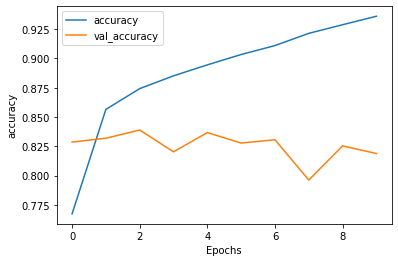

In [ ]:
plot_graphs(history, 'accuracy')

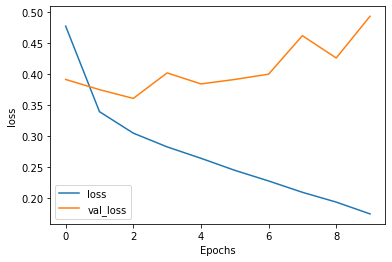

In [ ]:
plot_graphs(history, 'loss')